In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import glob
import tqdm


2023-03-01 10:12:51.056011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 10:12:51.056044: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 10:12:52.477944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-01 10:12:52.478039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-01 10:12:52.478052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
import PIL
import numpy as np
from PIL import Image
from numpy import asarray
# Open the image form working directory
num_train_samples=3000
from tqdm import tqdm

def getData(num_train_samples=1000,FILEPATHS=['../../datasets/AbdomenCT/*jpeg',
                       '../../datasets/HeadCT/*jpeg',
                       '../../datasets/ChestCT/*jpeg']):
    FILES={}
    count=0
    for i in FILEPATHS:
        FILES[count]=glob.glob(i)
        count=count+1
        
    NUM_CLASSES=len(FILEPATHS)
    ar_tr = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_tr=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    ar_ts = np.zeros([num_train_samples*NUM_CLASSES,64, 64, 3], dtype=np.uint8)
    label_ts=np.empty((num_train_samples*NUM_CLASSES,), dtype='uint8')
    count=0
    for f in tqdm(FILES[0]):
        #print('XX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count,:,:,1]=data
            ar_tr[count,:,:,2]=data
            ar_tr[count,:,:,0]=data
            label_tr[count]=0
        if count>=num_train_samples:
            data = asarray(image)
            ar_ts[count-num_train_samples,:,:,1]=data
            ar_ts[count-num_train_samples,:,:,2]=data
            ar_ts[count-num_train_samples,:,:,0]=data
            label_ts[count-num_train_samples]=0
        count=count+1
        if count==num_train_samples*2:
            break


    count=0
    for f in tqdm(FILES[1]):
        #print('XXX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count+num_train_samples,:,:,1]=data
            ar_tr[count+num_train_samples,:,:,2]=data
            ar_tr[count+num_train_samples,:,:,0]=data
            label_tr[count+num_train_samples]=1
        if count>=num_train_samples:
            data = asarray(image)
            #print(count)
            ar_ts[count,:,:,1]=data
            ar_ts[count,:,:,2]=data
            ar_ts[count,:,:,0]=data
            label_ts[count]=1
        count=count+1
        if count==num_train_samples*2:
            break

    count=0
    for f in tqdm(FILES[2]):
        #print('XXX',count)
        image = Image.open(f)
        if count <num_train_samples:
            data = asarray(image)
            ar_tr[count+2*num_train_samples,:,:,1]=data
            ar_tr[count+2*num_train_samples,:,:,2]=data
            ar_tr[count+2*num_train_samples,:,:,0]=data
            label_tr[count+2*num_train_samples]=2
        if count>=num_train_samples:
            data = asarray(image)
            #print(count)
            ar_ts[count+num_train_samples,:,:,1]=data
            ar_ts[count+num_train_samples,:,:,2]=data
            ar_ts[count+num_train_samples,:,:,0]=data
            label_ts[count+num_train_samples]=2
        count=count+1
        if count==num_train_samples*2:
            break
            
            
    x_train=ar_tr
    x_test=ar_ts
    y_train=label_tr
    y_test=label_ts
    return (x_train, y_train), (x_test, y_test)

In [3]:
(train_images, train_labels), (test_images, test_labels)=getData(num_train_samples)

 60%|██████████████████████▏              | 5999/10000 [00:11<00:07, 503.86it/s]


In [4]:
print(train_images.shape,len(train_labels))
print(test_images.shape,len(test_labels))


(9000, 64, 64, 3) 9000
(9000, 64, 64, 3) 9000


In [5]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

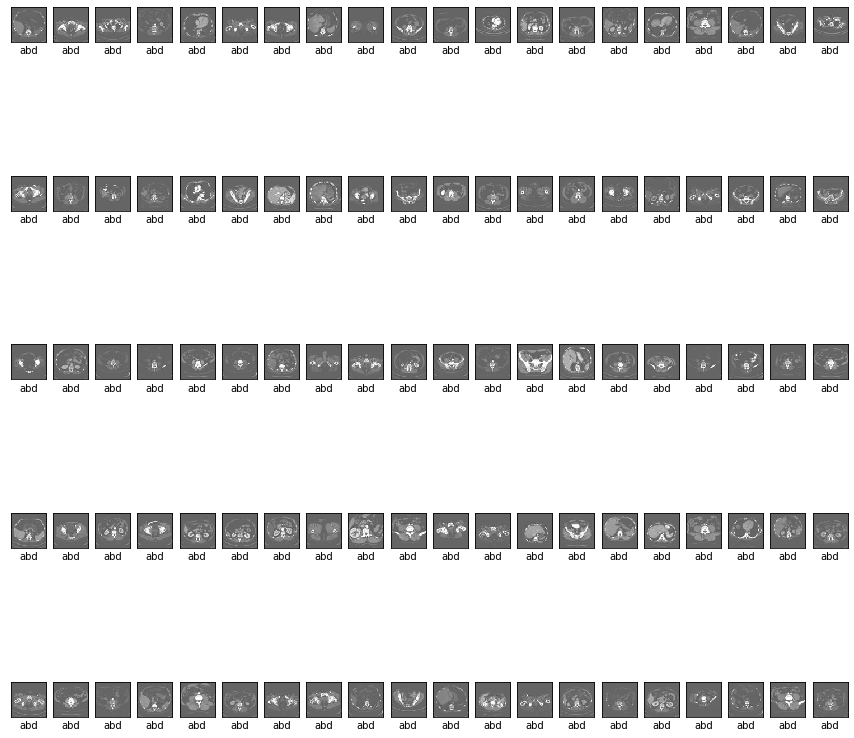

In [6]:
class_names = ['abd','bst','chst']
plt.figure(figsize=[15,15])
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])

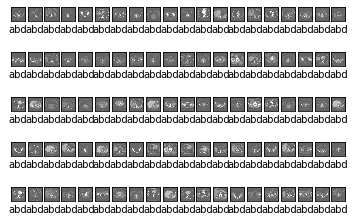

In [7]:
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[test_labels[i]])

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3,activation=tf.nn.softmax))

2023-03-01 10:13:53.421474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-01 10:13:53.421538: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-01 10:13:53.421569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xcalibur): /proc/driver/nvidia/version does not exist


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=3, 
                    validation_data=(test_images, test_labels))

Epoch 1/3


/home/ishanu/.local/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


282/282 [==============================] - 61s 207ms/step - loss: 0.0967 - accuracy: 0.9579 - val_loss: 0.0032 - val_accuracy: 0.9996
Epoch 2/3
282/282 [==============================] - 41s 146ms/step - loss: 0.0655 - accuracy: 0.9821 - val_loss: 0.0072 - val_accuracy: 0.9987
Epoch 3/3
282/282 [==============================] - 41s 146ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0037 - val_accuracy: 0.9990


282/282 - 9s - loss: 0.0037 - accuracy: 0.9990 - 9s/epoch - 31ms/step


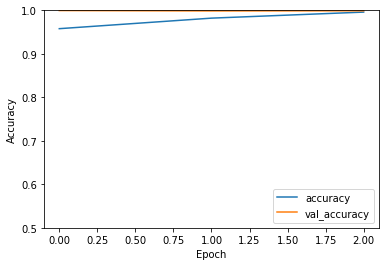

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [12]:
history.history

{'loss': [0.09674210101366043, 0.06548766791820526, 0.011730091646313667],
 'accuracy': [0.9578889012336731, 0.9821110963821411, 0.9959999918937683],
 'val_loss': [0.003213852643966675,
  0.007230690214782953,
  0.0036735322792083025],
 'val_accuracy': [0.9995555281639099, 0.9986666440963745, 0.9990000128746033]}